In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import readdy
print(readdy.__version__)

85-1234567


/home/chris/miniconda3/envs/tutorials/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
system = readdy.ReactionDiffusionSystem(
        box_size=(10, 10, 10), periodic_boundary_conditions=[True, True, True], unit_system=None)
system.add_species("A", 1.0)

In [3]:
simulation = system.simulation(kernel="SingleCPU")

simulation.output_file = "out_msd.h5"
simulation.observe.particle_positions(stride=1)
init_pos = np.zeros((800, 3))
simulation.add_particles("A", init_pos)

In [4]:
if os.path.exists(simulation.output_file):
    os.remove(simulation.output_file)

simulation.run(n_steps=5000, timestep=1e-3, show_system=True)

Configured kernel context with:
--------------------------------
 - kBT = 1
 - periodic b.c. = (true, true, true)
 - box size = (10, 10, 10)
 - particle types:
     *  particle type "A" with D=1



HBox(children=(HBox(children=(Label(value='Simulation progress'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=500), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

In [5]:
traj = readdy.Trajectory(simulation.output_file)
times, positions = traj.read_observable_particle_positions()
times = np.array(times) * 1e-3

In [6]:
# convert to pure numpy array to make use of fancy operations
T = len(positions)
N = len(positions[0])
pos = np.zeros(shape=(T, N, 3))
for t in range(T):
    for n in range(N):
        pos[t, n, 0] = positions[t][n][0]
        pos[t, n, 1] = positions[t][n][1]
        pos[t, n, 2] = positions[t][n][2]

Wrap the trajectories back to account for periodic boundaries
1. find the box index of each point in time for each particle and each coordinate
2. wrap the trajectory back to absolute positions for each particle using the box indices

In [7]:
box_size = 10.
box_indices = np.zeros(shape=(T, N, 3), dtype=int)
for t in range(1, T):
    for n in range(N):
        for coord in [0, 1, 2]:
            delta = pos[t, n, coord] - pos[t-1, n, coord]
            if delta > 0.5 * box_size:
                box_indices[t, n, coord] = box_indices[t-1, n, coord] - 1
            elif delta < - 0.5 * box_size:
                box_indices[t, n, coord] = box_indices[t-1, n, coord] + 1
            else:
                box_indices[t, n, coord] = box_indices[t-1, n, coord]

In [8]:
wrapped_pos = np.zeros_like(pos)
for t in range(T):
    for n in range(N):
        wrapped_pos[t, n] = pos[t, n] + box_indices[t, n].astype(float) * box_size

In [9]:
difference = wrapped_pos - init_pos
squared_displacements = np.sum(difference * difference, axis=2)  # sum over coordinates, per particle per timestep
squared_displacements = squared_displacements.transpose()  # T x N -> N x T

In [10]:
def average_across_first_axis(values):
    n_values = len(values)
    mean = np.sum(values, axis=0) / n_values
    difference = values - mean  # broadcasting starts with last axis
    std_dev = np.sqrt(np.sum(difference * difference, axis=0) / n_values)
    std_err = np.sqrt(np.sum(difference * difference, axis=0) / n_values ** 2)
    return mean, std_dev, std_err

mean, std_dev, std_err = average_across_first_axis(squared_displacements)

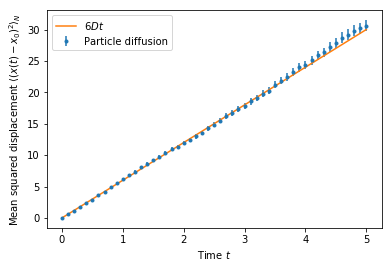

In [11]:
stride = 100
plt.errorbar(times[::stride], mean[::stride], yerr=std_err[::stride], fmt=".", label="Particle diffusion")
plt.plot(times[::stride], 6. * times[::stride], label=r"$6 D t$")
plt.legend(loc="best")
plt.xlabel(r"Time $t$")
plt.ylabel(r"Mean squared displacement $\langle (x(t) - x_0)^2 \rangle_N$")
plt.show()